# Creating Simple Interactive Corendering Displays

With the [capability to load seismic data](https://github.com/iandeniset/GeophysicsNotebooks/blob/master/LoadingOpendTectSeismic.ipynb) as a simple text file then [display it in an interactive manner](https://github.com/iandeniset/GeophysicsNotebooks/blob/master/InteractiveSeismicDisplays.ipynb) we now have the ability to manipulate data any way we want and display it in an efficient and customizable way via [NumPy](http://www.numpy.org/)/[SciPy](https://www.scipy.org/) and [matplotlib](http://matplotlib.org/).  The limitations of what we can do with the data is now only set by what can be imagined.  Two perfect examples that illustrate this concept, due to their common place in the interpreter's toolkit, are semblance/coherency/similarity attribute generation and corendering of different seismic volumes.  

Below I'll run through an example that shows how easily both of these things can be achieved in Python.  But first, the motivation...  

## Motivation
It seems to be the case all too often, that a person is limited to their choice in algorithim and corendering functionality based solely on the software package they use on a day to day.  Most suites usually only offer one 'proprietary' similarity attribute (explained terribly in the help menu) and very limited (if any), corendering functionality.  To me that seems unfortunate and very restricting.  Can we not not simply select the algorithm we want and subsequently corender the generated attribute volume with the original seismic in straightforward manner?  Yes we can!  We can do it with Python, and it only take a few lines of code.  

The first place to start is calculating the similarity volume itself...

### Calculating Similarity
The basic idea of similarity is to compare neighbouring traces in a seismic data set to one another and determine if they are alike in character or not.  Basically it is a 3D edge detection filter use to pick up on subtle differences in the seismic response.  As stated before, the common issue in the calculation of similarity is simply the lack of choice in algorithm.  With Python however, that problem disappears, as you can simply write whatever version of the algorithm you want! 

...or you can do what I did and repurpose the awesome and in depth work done by Joe Kington found [here](https://github.com/seg/tutorials/blob/master/1512_Semblance_coherence_and_discontinuity/Discontinuity_tutorial.ipynb) on calculating similarity in Python.

So without further ado, let's load in some data and generate a similarity volume.

In [1]:
#all the usuals
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import scipy.ndimage #for similarity calculation
import scipy.signal  #for similarity calculation
from ipywidgets import interact
import create_data

As before, I will be loading in the Penobscot 3D data set obtained from the [Open Seismic Repository](https://opendtect.org/osr/).

In [2]:
#download the subset volume I am using from the link below so you can follow along
#https://www.dropbox.com/s/y0nlkl2ykksk1ba/PEN3D_Test.txt?dl=1
from create_data import create_data

ascii_seis = np.loadtxt('/Users/IanDeniset/Desktop/PEN3D_Test.txt')
print ('The shape of the imported file is: ' , ascii_seis.shape)

seismic = create_data(ascii_seis)

The shape of the imported file is:  (288678, 503)
The inline min and max are:  1000.0 1600.0
The crossline min and max are:  1000.0 1480.0
The number of inlines is:  600.0
The number of crosslines is:  480.0
The number of time samples are:  501.0
The shape of the mapped data empty matrix is : (600, 480, 501)


Let's plot up a time slice to make sure that data loaded properly…

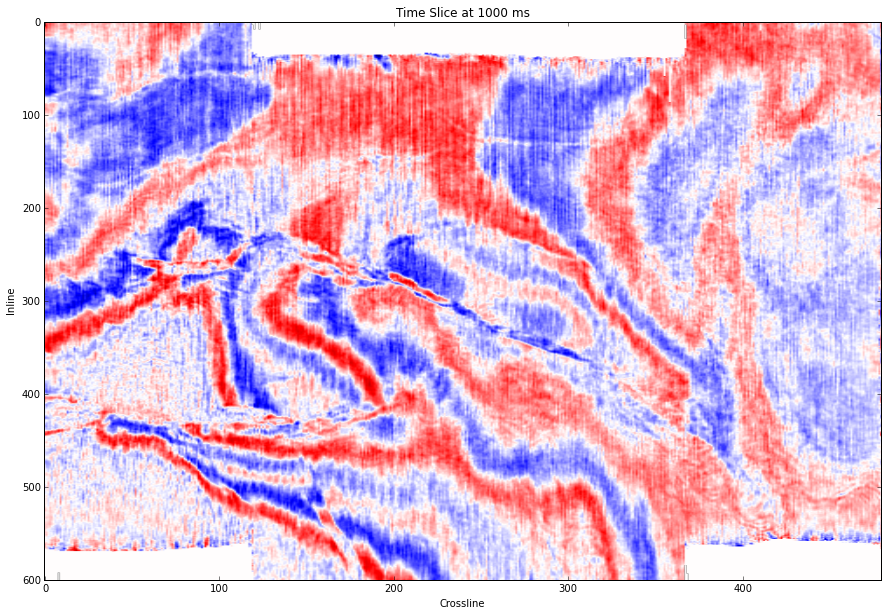

In [3]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(seismic[:,::-1,(1000//4)], aspect='auto', cmap='seismic', clim=(-10000,10000))
ax.set_title('Time Slice at 1000 ms')
ax.set_ylabel('Inline')
ax.set_xlabel('Crossline')
plt.show()

Perfect, looks like everything loaded up good.  The next step is to create a sub cube from the original seismic volume simply to minimize computation time when generating the attribute volume.  Let's create a cube from 600 ms to 1200 ms, inline 200-400, and crossline 150-300:

In [4]:
seis_sub = seismic[200:400,150:300,(600//4):(1200//4)]  #sample interval of 4 ms
print (seis_sub.shape)

(200, 150, 150)


With the sub cube created, lets generate a similarity volume using the classic Marfurt (1998) algorithm written by Joe K.  

*N.B. This is copied directly from the SEG Tutorial linked above.*

In [5]:
def moving_window(data, window, func):
    # `generic_filter` will give the function 1D input. We'll reshape it for convinence
    wrapped = lambda region: func(region.reshape(window))
    
    # Instead of an explicit for loop, we'll use a scipy function to do the same thing
    # The boundaries will be handled by "reflecting" the data, by default
    return scipy.ndimage.generic_filter(data, wrapped, window)

def marfurt_semblance(region):
    # We'll need an ntraces by nsamples array
    # This stacks all traces within the x-y "footprint" into one
    # two-dimensional array.
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    square_of_sums = np.sum(region, axis=0)**2
    sum_of_squares = np.sum(region**2, axis=0)
    sembl = square_of_sums.sum() / sum_of_squares.sum()
    return sembl / ntraces

In [6]:
marfurt_semb = moving_window(seis_sub, (3, 3, 9), marfurt_semblance)
print('The shape of the similarity cube is: ', marfurt_semb.shape)

The shape of the similarity cube is:  (200, 150, 150)


The shape looks good.  Let's plot up an interactive timeslice just to be sure everything turned out ok:

In [7]:
def timeslice(SliceTime=1000):
    
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(marfurt_semb[:,::-1,(SliceTime-600)//4], cmap='gray', aspect='auto')
    ax.set_title('Time Slice at %d' % SliceTime)
    ax.set_ylabel('Inline')
    ax.set_xlabel('Crossline')
    
    plt.show()

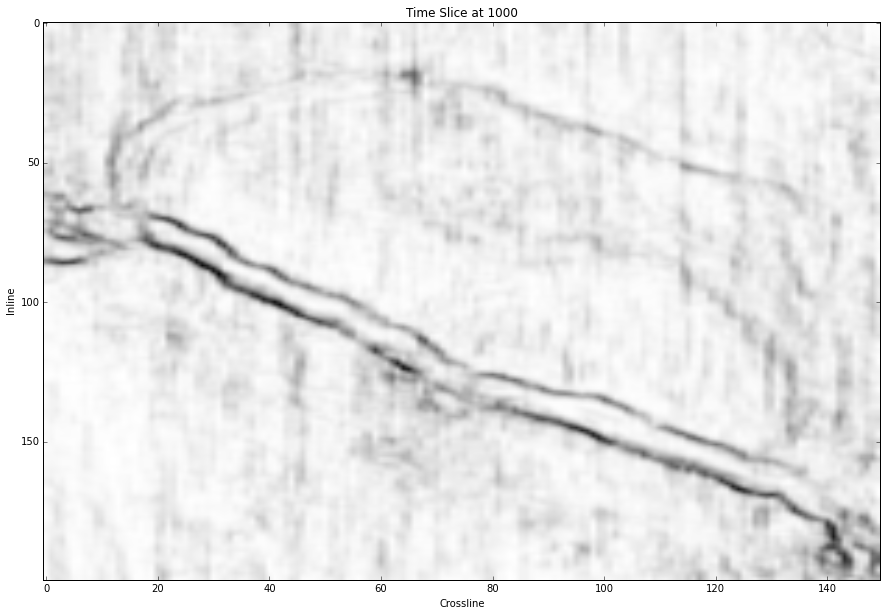

<function __main__.timeslice>

In [8]:
#see the notebook mentioned above for more information on sliders
interact(timeslice, SliceTime=(0,2000,4))

## Corendering the Simple Way 
With the similarity volume calculated, the next step is to corender it with the seismic volume in order to enhance feature detection.  In Python, the solution is straightforward and elegant, producing a very simple yet effective visualization technique via simple simultaneous plotting and transparency control.  

Let's take a look at the code involved.

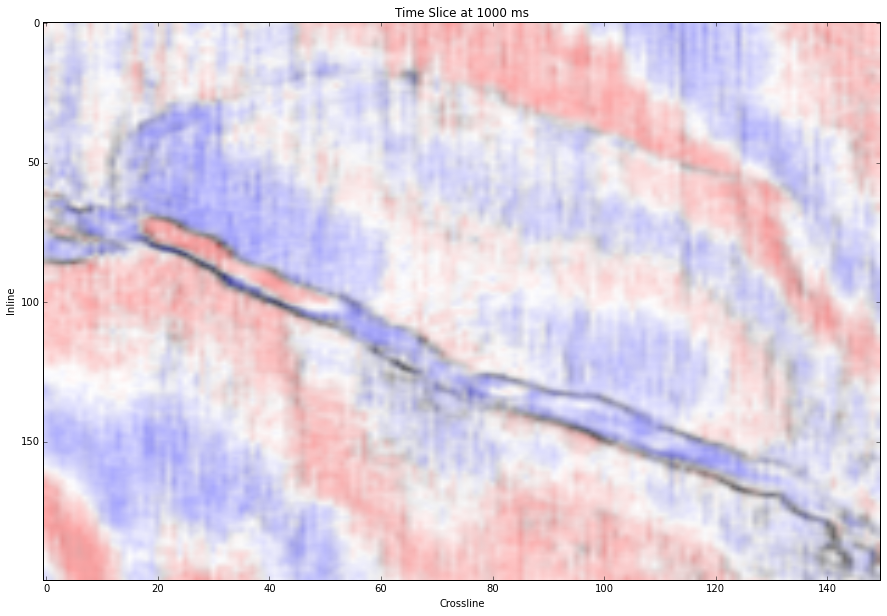

In [9]:
fig , ax = plt.subplots(figsize=(15,10))
ax.imshow(marfurt_semb[:,::-1,100], cmap='gray', aspect='auto')
ax.imshow(seis_sub[:,::-1,100], cmap='seismic', clim=(-10000,10000), aspect='auto', alpha=0.35)
ax.set_title('Time Slice at 1000 ms')
ax.set_ylabel('Inline')
ax.set_xlabel('Crossline')
plt.show()
plt.show()

Pretty good for a first pass!  Though, the seismic looks a little washed out which makes me think that the 'alpha' opacity parameter could use some tweaking.  Also, it would be nice to take a look at some other times to explore other features in the data set.  Time to go interactive!

Lets define a function to corender the two volumes as we did before so that it can be called with the interact module and allow us to change the opacity and slice location on the fly:

In [10]:
def time_slice_corendered(SliceTime=1000, OpacitySeismic=0.35):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(marfurt_semb[:,::-1,(SliceTime-600)//4], cmap='gray', aspect='auto')
    ax.imshow(seis_sub[:,::-1,(SliceTime-600)//4], cmap='seismic', clim=(-10000,10000), 
              alpha=OpacitySeismic, aspect='auto')
    ax.set_title('Co-Rendered Time Slice at %d ms' % SliceTime)
    plt.show()

Now let's call the function with interact:

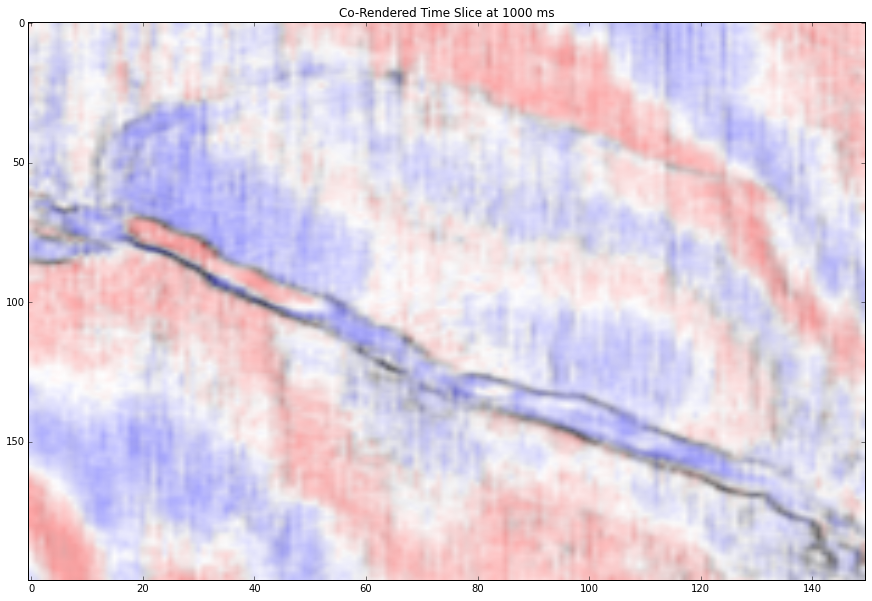

In [11]:
interact(time_slice_corendered, SliceTime=(600,1200,4), OpacitySeismic=(0.0,1.0,0.01));

There we go!  A interactive (albeit a very simple one) corendered display created in less than 10 lines of code!  The awesome thing about this method is that it can be applied to any two volumes you load, not just seismic and similarity.

The next step in this would be to corender volumes without one attribute looking so washed out as the seismic appears above.  To do this, I think the two slice 'images' would need to be combined into one, or a clipping function would have to be applied...things to think about and attempt at a later date.  For now, this is a quick and dirty, yet very effective solution.